In [107]:
#Make necessary imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [109]:
#Load drivers dataset as CSV
drivers = pd.read_csv('/content/drive/MyDrive/drivers (2).csv')

In [110]:
drivers

,NHDPlusID,Date,etalfalfa,etgrass,prcp,rhmax,rhmin,srad,sph,tmax,tmin,vp,ws
0,55000900202941,1980-01-01,0.800000,0.500000,13.300000,100.0,73.099998,53.900002,0.004850,280.500000,272.600006,0.100000,4.1
1,55000900271015,1980-01-01,0.600000,0.400000,13.300000,100.0,79.099998,50.400002,0.005010,280.600006,272.700012,0.060000,4.1
2,55000900029009,1980-01-01,0.600000,0.400000,13.300000,100.0,79.099998,50.400002,0.005010,280.600006,272.700012,0.060000,4.1
3,55000900236503,1980-01-01,0.600000,0.400000,13.300000,100.0,79.099998,50.400002,0.005010,280.600006,272.700012,0.060000,4.1
4,55000900099082,1980-01-01,0.755416,0.553249,12.812998,100.0,75.191687,52.779247,0.004664,279.995667,272.242418,0.095975,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875963,55000900064194,2020-12-31,0.100000,0.100000,13.503330,100.0,87.876994,41.032998,0.005002,277.478002,272.405494,0.000000,6.5
11875964,55000900202426,2020-12-31,0.100000,0.100000,14.800000,100.0,90.599998,42.200001,0.004970,276.700012,272.600006,0.000000,6.5
11875965,55000900271017,2020-12-31,0.100000,0.100000,12.800000,100.0,86.400002,40.400002,0.005020,277.899994,272.299988,0.000000,6.5
11875966,55000900202422,2020-12-31,0.100000,0.100000,14.600000,100.0,93.599998,42.500000,0.005110,276.700012,273.200012,0.000000,6.3


In [137]:
#Loads obs data
data = pd.read_parquet('obs.parquet')

In [168]:
data

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [139]:
#Isolate the target variable by creating dictionary of all metrics and choosing 'value'
dfs = {val: data[data['variable'] == val ]for val in data['variable'].unique()}

wet_dry_df = dfs['HoboWetDry0.05']

In [140]:
#Load in remaining datasets
static_df = pd.read_parquet('static_vars.parquet')
degrees = pd.read_parquet('degrees.parquet')

In [141]:
#Make sure all NHD IDs are strings, normalize before merging
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)

#Make sure all date values are in datetime format, normalize before merging
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

#Merge all datasets to create one central dataset
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

/tmp/ipython-input-1315269600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
/tmp/ipython-input-1315269600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])


In [142]:
#Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

#Introduce lag by shifting the label back
#EXPERIMENT WITH THIS VALUE (which is currently -7)
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-7)

#Drop all null values
central_df = central_df.dropna(subset = 'wet_dry_next')

## **Random Splitting Approach**

In [143]:
#Features and target
X = central_df.drop('wet_dry_next', axis=1)
y = central_df['wet_dry_next']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## **Temporal Splitting Approach**

In [144]:
#Sort by time
df = central_df.sort_values(['Date'])
split_date = '2020-9-15'

#Introduce temporal based splitting
#Every entry before 9/15 is training; rest is testing
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]

X_train = train.drop('wet_dry_next', axis=1)
y_train = train['wet_dry_next']
X_test = test.drop('wet_dry_next', axis=1)
y_test = test['wet_dry_next']

## **Site-based Splitting Approach**

In [145]:
#Sort data chronologically
central_df = central_df.sort_values(['Date']).reset_index(drop=True)

#Split sites into train and test groups
sites = central_df['SiteIDCode'].unique()
train_sites = sites[:int(0.8 * len(sites))]
test_sites  = sites[int(0.8 * len(sites)):]

#Create site-based train and test sets
train = central_df[central_df['SiteIDCode'].isin(train_sites)].copy()
test  = central_df[central_df['SiteIDCode'].isin(test_sites)].copy()

#Features and target
X_train = train.drop('wet_dry_next', axis=1)
y_train = train['wet_dry_next']
X_test = test.drop('wet_dry_next', axis=1)
y_test = test['wet_dry_next']

In [146]:
#Drop non-numerical, non-influential columns
X_train = X_train.drop(['variable', 'NHDPlusID',	'SiteIDCode',	'Date'], axis = 1)
X_test = X_test.drop(['variable', 'NHDPlusID',	'SiteIDCode',	'Date'], axis = 1)

In [147]:
#Apply SMOTE to fix class imbalance
sm = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [148]:
#Define XGBoost model and fit it on training data
XGB_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [149]:
#Apply model onto test data and save predictions
y_pred = XGB_model.predict(X_test)

#Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [150]:
accuracy

0.6636528028933092

In [151]:
roc

np.float64(0.6194581280788177)

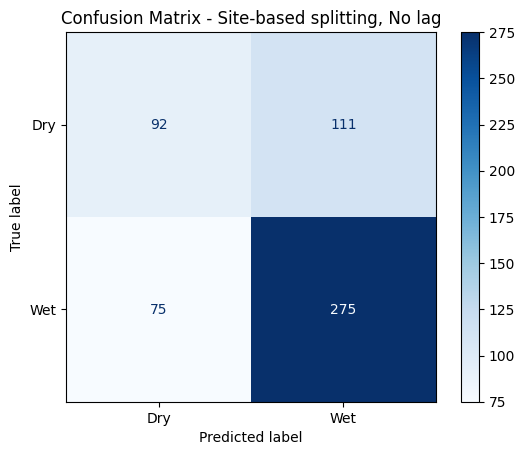

In [152]:
#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - Site-based splitting, No lag")
plt.show()

In [153]:
#Make feature importances table
feature_cols = X_train.columns.tolist()

importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": XGB_model.feature_importances_
})

print(importances)


           Feature  Importance
0            value    0.439087
1        etalfalfa    0.004254
2          etgrass    0.005183
3             prcp    0.005577
4            rhmax    0.011850
5            rhmin    0.005777
6             srad    0.013640
7              sph    0.003438
8             tmax    0.003943
9             tmin    0.003419
10              vp    0.011543
11              ws    0.004308
12      ArbolateSu    0.055235
13        AreaSqKm    0.003921
14        FromNode    0.000000
15        LengthKM    0.029983
16           Slope    0.077143
17          ToNode    0.000000
18       TotDASqKm    0.002685
19   aspect_ne_pct    0.009927
20   aspect_nw_pct    0.004789
21   aspect_se_pct    0.171857
22   aspect_sw_pct    0.128507
23       curv_mean    0.000000
24     curv_median    0.000000
25     elev_max_cm    0.000000
26    elev_mean_cm    0.002187
27  elev_median_cm    0.000000
28     elev_min_cm    0.000000
29    slp_mean_pct    0.000000
30  slp_median_pct    0.000000
31      

In [179]:
#Define function to make predictions given site and date
def predict_site_date(model, central_df, site_id, date):
  date = pd.to_datetime(date)
  site_id = str(site_id)

  row = central_df[(central_df["SiteIDCode"] == site_id) & (central_df["Date"] == date)]
  Xq = row[feature_cols]

  pred_class = model.predict(Xq)
  pred_prob = model.predict_proba(Xq)[:, 1]

  return f"Site {site_id} on {date.date()}: {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={pred_prob})"

In [180]:
predict_site_date(
    model=XGB_model,
    central_df=central_df,
    site_id="HoboSite100",
    date="2020-10-22"
)

'Site HoboSite100 on 2020-10-22: DRY, (P(wet)=[0.0441328])'